In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TRX

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/TRX-USD.csv')
df1=df.reset_index()['Close']
df1

0       0.002118
1       0.002073
2       0.002116
3       0.002144
4       0.002085
          ...   
2012    0.078347
2013    0.078234
2014    0.076741
2015    0.077495
2016    0.071984
Name: Close, Length: 2017, dtype: float64

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:2:1

In [ ]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 20s 561ms/step - loss: 0.0077 - val_loss: 0.0014
Epoch 2/100
21/21 [==============================] - 10s 512ms/step - loss: 0.0021 - val_loss: 8.0527e-04
Epoch 3/100
21/21 [==============================] - 10s 485ms/step - loss: 0.0016 - val_loss: 6.2063e-04
Epoch 4/100
21/21 [==============================] - 6s 285ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/100
21/21 [==============================] - 4s 207ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/100
21/21 [==============================] - 6s 294ms/step - loss: 0.0012 - val_loss: 6.4687e-04
Epoch 7/100
21/21 [==============================] - 5s 239ms/step - loss: 0.0012 - val_loss: 5.5778e-04
Epoch 8/100
21/21 [==============================] - 5s 227ms/step - loss: 0.0011 - val_loss: 9.5726e-04
Epoch 9/100
21/21 [==============================] - 6s 314ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/100
21/21 [==============================] - 4s 214ms/step 

In [ ]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 61ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

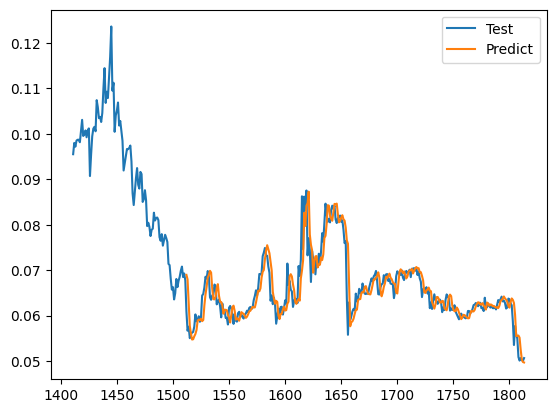

In [ ]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

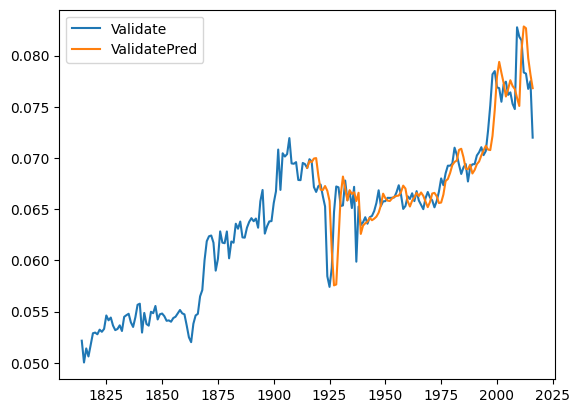

In [ ]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 77.3232383518216
MAE: 0.23623198900025744
RMSE: 0.23738545381080445
--------------------------
---------TEST----------
MAPE: 77.1475634457693
MAE: 0.22454271232614367
RMSE: 0.22673933394538145
-------------------


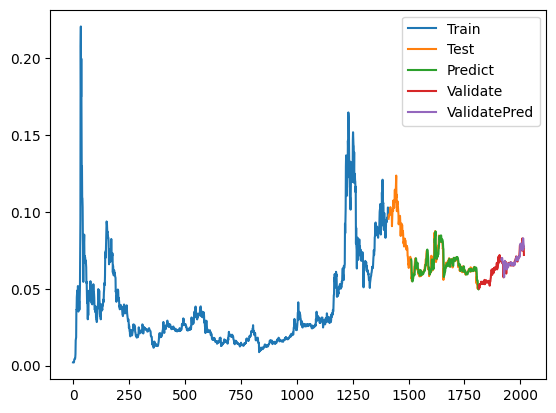

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [ ]:
val_data.shape

(203, 1)

In [ ]:
# Predict 7days
x_input=val_data[102:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.30930696 0.29790097 0.29572689 0.29834497 0.29900862 0.29379995
 0.28920919 0.2580716  0.2533115  0.26180189 0.28669181 0.29818019
 0.29778199 0.28945176 0.28969892 0.30081198 0.29203321 0.29611592
 0.28852719 0.29801084 0.26456185 0.28922294 0.2808927  0.28217428
 0.28443078 0.28151976 0.28442617 0.2850029  0.28719529 0.2908386
 0.29645005 0.28944719 0.29150228 0.29160299 0.2930951  0.29304473
 0.29311341 0.29329647 0.29558042 0.29871112 0.29457347 0.28813816
 0.28943348 0.29377706 0.29260076 0.29512271 0.29160756 0.2960839
 0.29190506 0.28990947 0.28802375 0.29293946 0.29569483 0.293237
 0.29196914 0.28885675 0.29165332 0.2958459  0.30176856 0.29874314
 0.30405709 0.30745326 0.30744869 0.30840528 0.3154951  0.31240103
 0.30789266 0.30375958 0.30669805 0.30819473 0.30040003 0.3067667
 0.30806658 0.30816271 0.312012   0.31346292 0.31571938 0.3121676
 0.31399384 0.32303349 0.33435709 0.34828956 0.3497222  0.34247674
 0.34208768 0.33602769 0.34380865 0.34499412 0.33909888 

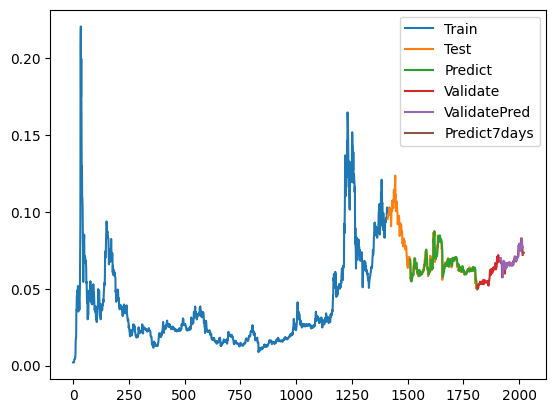

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

## 5:3:2

In [ ]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [ ]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [ ]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [ ]:
model1=Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model1.add(LSTM(50,return_sequences=True))
model1.add(LSTM(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 13s 415ms/step - loss: 0.0039 - val_loss: 0.0203
Epoch 2/100
15/15 [==============================] - 4s 264ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 3/100
15/15 [==============================] - 4s 242ms/step - loss: 6.6149e-04 - val_loss: 0.0038
Epoch 4/100
15/15 [==============================] - 4s 252ms/step - loss: 5.9052e-04 - val_loss: 0.0033
Epoch 5/100
15/15 [==============================] - 6s 368ms/step - loss: 5.3476e-04 - val_loss: 0.0036
Epoch 6/100
15/15 [==============================] - 4s 248ms/step - loss: 4.8114e-04 - val_loss: 0.0028
Epoch 7/100
15/15 [==============================] - 4s 244ms/step - loss: 4.4842e-04 - val_loss: 0.0026
Epoch 8/100
15/15 [==============================] - 5s 367ms/step - loss: 4.5356e-04 - val_loss: 0.0037
Epoch 9/100
15/15 [==============================] - 4s 256ms/step - loss: 4.6679e-04 - val_loss: 0.0028
Epoch 10/100
15/15 [==============================] - 4s 250ms

In [ ]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 47ms/step


In [ ]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

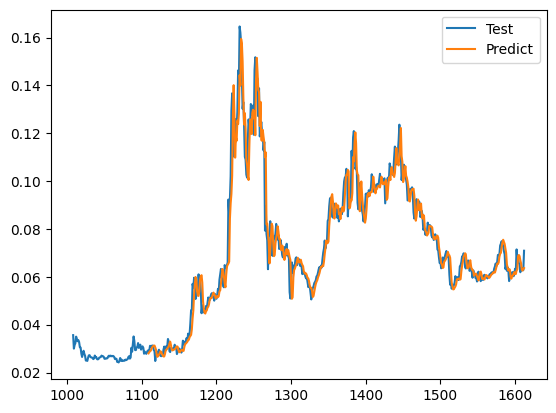

In [ ]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1 + test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start = train_size1 + 101, stop = train_size1 + test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

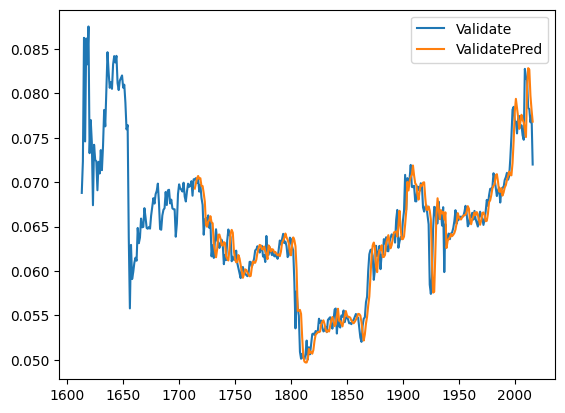

In [ ]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 77.11474009662601
MAE: 0.21641405392833446
RMSE: 0.21857125196331115
--------------------------
---------TEST----------
MAPE: 73.59877218133826
MAE: 0.25761711743049615
RMSE: 0.28785012530235743
-------------------


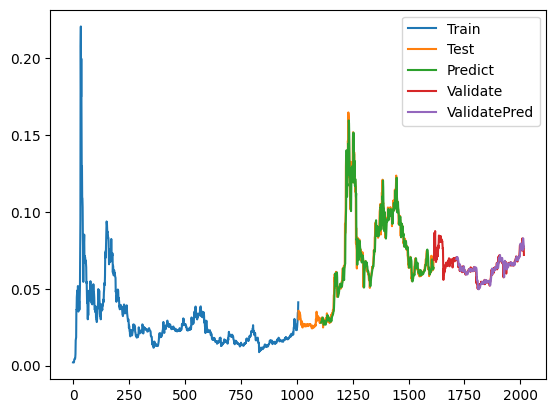

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [ ]:
val_data1.shape

(404, 1)

In [ ]:
x_input=val_data1[303:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps_1=100
i=0

while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps_1, 1))
        #print(x_input)
        yhat = model1.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps_1,1))
        yhat = model1.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.30930696 0.29790097 0.29572689 0.29834497 0.29900862 0.29379995
 0.28920919 0.2580716  0.2533115  0.26180189 0.28669181 0.29818019
 0.29778199 0.28945176 0.28969892 0.30081198 0.29203321 0.29611592
 0.28852719 0.29801084 0.26456185 0.28922294 0.2808927  0.28217428
 0.28443078 0.28151976 0.28442617 0.2850029  0.28719529 0.2908386
 0.29645005 0.28944719 0.29150228 0.29160299 0.2930951  0.29304473
 0.29311341 0.29329647 0.29558042 0.29871112 0.29457347 0.28813816
 0.28943348 0.29377706 0.29260076 0.29512271 0.29160756 0.2960839
 0.29190506 0.28990947 0.28802375 0.29293946 0.29569483 0.293237
 0.29196914 0.28885675 0.29165332 0.2958459  0.30176856 0.29874314
 0.30405709 0.30745326 0.30744869 0.30840528 0.3154951  0.31240103
 0.30789266 0.30375958 0.30669805 0.30819473 0.30040003 0.3067667
 0.30806658 0.30816271 0.312012   0.31346292 0.31571938 0.3121676
 0.31399384 0.32303349 0.33435709 0.34828956 0.3497222  0.34247674
 0.34208768 0.33602769 0.34380865 0.34499412 0.33909888 

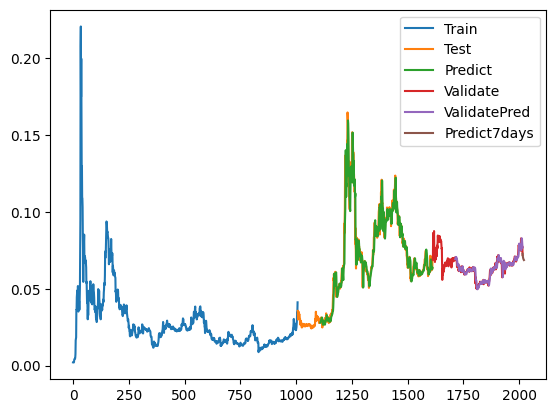

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

## 6:2:2

In [ ]:
train_size2 = int(0.6 * len(df1))
test_size2 = int(0.2 * len(df1))
val_size2 = len(df1) - train_size2 - test_size2

train_data2 = df1[:train_size2]
test_data2 = df1[train_size2:train_size2 + test_size2]
val_data2 = df1[train_size2 + test_size2:]

In [ ]:
time_step = 100
X_train2, y_train2 = create_dataset(train_data2, time_step)
X_val2, yval2 = create_dataset(val_data2, time_step)
X_test2, ytest2 = create_dataset(test_data2, time_step)

In [ ]:
X_train2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1], 1)
X_test2 = X_test2.reshape(X_test2.shape[0],X_test2.shape[1], 1)
X_val2 = X_val2.reshape(X_val2.shape[0],X_val2.shape[1], 1)

In [ ]:
model2=Sequential()
model2.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model2.add(LSTM(50,return_sequences=True))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(X_train2,y_train2,validation_data=(X_test2,ytest2),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 [==============================] - 12s 288ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 2/100
18/18 [==============================] - 6s 329ms/step - loss: 9.8900e-04 - val_loss: 0.0026
Epoch 3/100
18/18 [==============================] - 4s 216ms/step - loss: 6.9861e-04 - val_loss: 0.0019
Epoch 4/100
18/18 [==============================] - 4s 210ms/step - loss: 6.1586e-04 - val_loss: 0.0012
Epoch 5/100
18/18 [==============================] - 5s 309ms/step - loss: 5.4710e-04 - val_loss: 0.0019
Epoch 6/100
18/18 [==============================] - 4s 242ms/step - loss: 4.9616e-04 - val_loss: 0.0014
Epoch 7/100
18/18 [==============================] - 4s 215ms/step - loss: 4.6800e-04 - val_loss: 0.0030
Epoch 8/100
18/18 [==============================] - 5s 274ms/step - loss: 4.4860e-04 - val_loss: 0.0044
Epoch 9/100
18/18 [==============================] - 5s 265ms/step - loss: 4.4139e-04 - val_loss: 0.0014
Epoch 10/100
18/18 [==============================] - 4s 2

In [ ]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

10/10 [==============================] - 0s 48ms/step


In [ ]:
train_predict2 = scaler.inverse_transform(train_predict2)
y_pred2 = scaler.inverse_transform(y_pred2)
y_pred_val2 = scaler.inverse_transform(y_pred_val2)

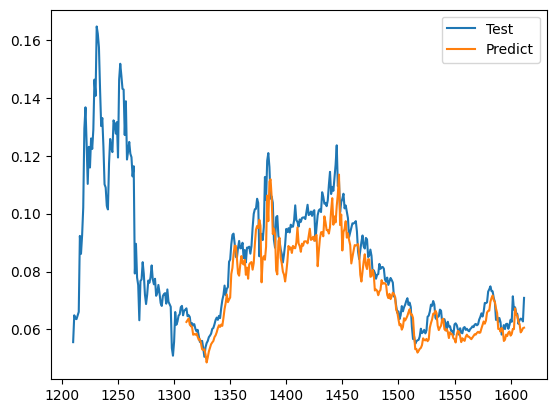

In [ ]:
test_data_index2 = pd.RangeIndex(start=train_size2, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,scaler.inverse_transform(test_data2))

test_data_index2 = pd.RangeIndex(start=train_size2+101, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,(y_pred2))

plt.legend(['Test','Predict'])
plt.show()

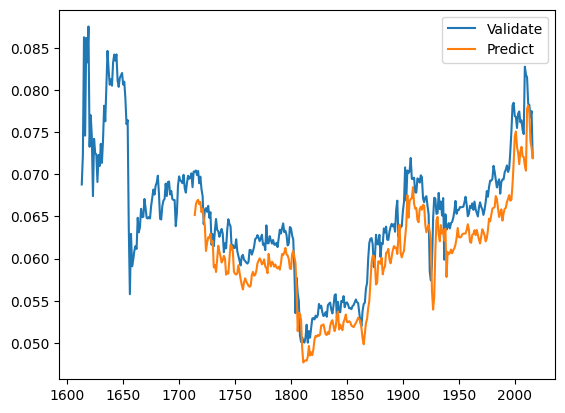

In [ ]:
val_data_index2 = pd.RangeIndex(start=train_size2+test_size2, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,scaler.inverse_transform(val_data2))

val_data_index2 = pd.RangeIndex(start=train_size2+test_size2+101, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,y_pred_val2)

plt.legend(['Validate','Predict'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape2 = np.mean(np.abs((yval2 - y_pred_val2) / yval2)) * 100
print('MAPE:', valid_mape2)

valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mape2 = np.mean(np.abs((ytest2 - y_pred2) / ytest2)) * 100
print('MAPE:', test_mape2)

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAPE: 78.22192707609622
MAE: 0.21947515312141488
RMSE: 0.22158601590644242
--------------------------
---------TEST----------
MAPE: 77.96621515215604
MAE: 0.2766100443970524
RMSE: 0.2883607134027004
-------------------


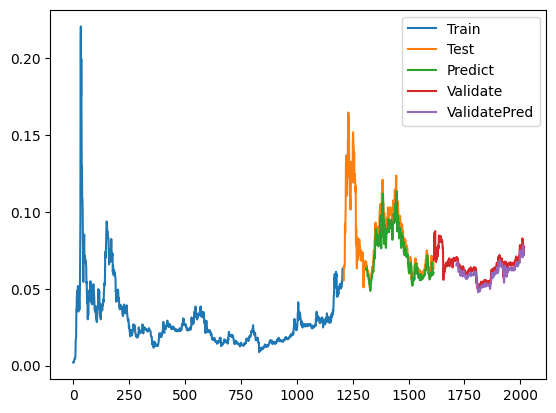

In [ ]:
train_data_index2 = pd.RangeIndex(start=0, stop=train_size2, step=1)
plt.plot(scaler.inverse_transform(train_data2))

test_data_index2 = pd.RangeIndex(start=train_size2, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,scaler.inverse_transform(test_data2))
test_data_index2 = pd.RangeIndex(start=train_size2+101, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,(y_pred2))

val_data_index2 = pd.RangeIndex(start=train_size2+test_size2, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,scaler.inverse_transform(val_data2))
val_data_index2 = pd.RangeIndex(start=train_size2+test_size2+101, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,y_pred_val2)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [ ]:
val_data2.shape

(404, 1)

In [ ]:
# Predict 7 days
x_input=val_data2[303:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model2.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model2.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.30930696 0.29790097 0.29572689 0.29834497 0.29900862 0.29379995
 0.28920919 0.2580716  0.2533115  0.26180189 0.28669181 0.29818019
 0.29778199 0.28945176 0.28969892 0.30081198 0.29203321 0.29611592
 0.28852719 0.29801084 0.26456185 0.28922294 0.2808927  0.28217428
 0.28443078 0.28151976 0.28442617 0.2850029  0.28719529 0.2908386
 0.29645005 0.28944719 0.29150228 0.29160299 0.2930951  0.29304473
 0.29311341 0.29329647 0.29558042 0.29871112 0.29457347 0.28813816
 0.28943348 0.29377706 0.29260076 0.29512271 0.29160756 0.2960839
 0.29190506 0.28990947 0.28802375 0.29293946 0.29569483 0.293237
 0.29196914 0.28885675 0.29165332 0.2958459  0.30176856 0.29874314
 0.30405709 0.30745326 0.30744869 0.30840528 0.3154951  0.31240103
 0.30789266 0.30375958 0.30669805 0.30819473 0.30040003 0.3067667
 0.30806658 0.30816271 0.312012   0.31346292 0.31571938 0.3121676
 0.31399384 0.32303349 0.33435709 0.34828956 0.3497222  0.34247674
 0.34208768 0.33602769 0.34380865 0.34499412 0.33909888 

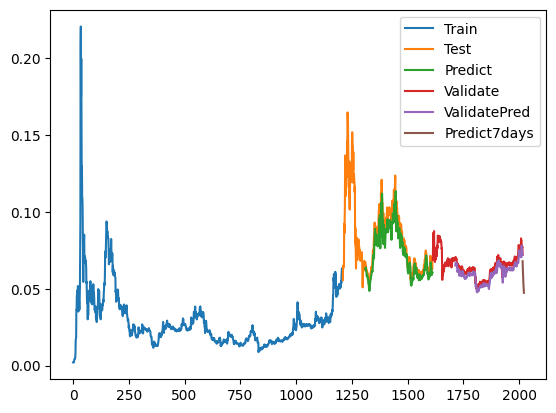

In [ ]:
train_data_index2 = pd.RangeIndex(start=0, stop=train_size2, step=1)
plt.plot(scaler.inverse_transform(train_data2))

test_data_index2 = pd.RangeIndex(start=train_size2, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,scaler.inverse_transform(test_data2))

test_data_index2 = pd.RangeIndex(start=train_size2+101, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,(y_pred2))

val_data_index2 = pd.RangeIndex(start=train_size2+test_size2, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,scaler.inverse_transform(val_data2))
val_data_index2 = pd.RangeIndex(start=train_size2+test_size2+101, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,y_pred_val2)

prediect_data_index2 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index2,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

# DOGE

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv')
df1=df.reset_index()['Close']
df1

0       0.002148
1       0.002149
2       0.002223
3       0.002463
4       0.002479
          ...   
2012    0.066573
2013    0.070373
2014    0.067300
2015    0.067966
2016    0.069489
Name: Close, Length: 2017, dtype: float64

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:2:1

In [ ]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 14s 287ms/step - loss: 0.0071 - val_loss: 5.0790e-04
Epoch 2/100
21/21 [==============================] - 6s 272ms/step - loss: 0.0024 - val_loss: 4.3035e-04
Epoch 3/100
21/21 [==============================] - 5s 249ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 4/100
21/21 [==============================] - 4s 213ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 5/100
21/21 [==============================] - 6s 294ms/step - loss: 0.0016 - val_loss: 0.0063
Epoch 6/100
21/21 [==============================] - 5s 218ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 7/100
21/21 [==============================] - 5s 216ms/step - loss: 0.0017 - val_loss: 7.2853e-04
Epoch 8/100
21/21 [==============================] - 7s 327ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/100
21/21 [==============================] - 4s 209ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 10/100
21/21 [==============================] - 5s 224ms/step - loss: 0.

In [ ]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 45ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

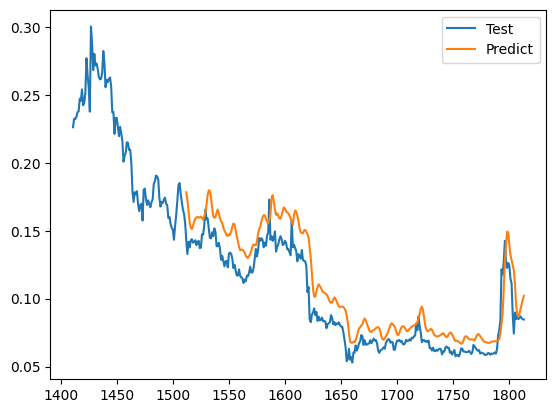

In [ ]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

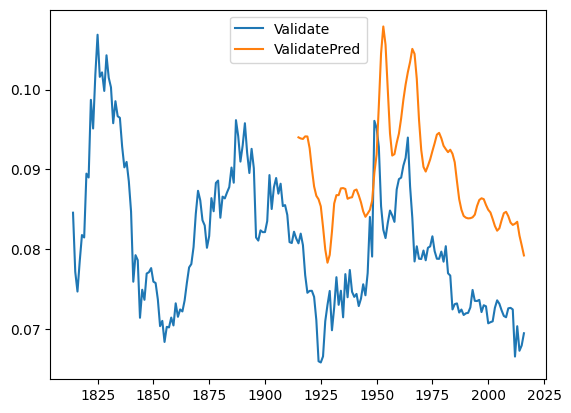

In [ ]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 18.69150991420075
MAE: 0.021225403110923014
RMSE: 0.02397732872696936
--------------------------
---------TEST----------
MAPE: 38.67968651094525
MAE: 0.055011813393030094
RMSE: 0.0681711627834372
-------------------


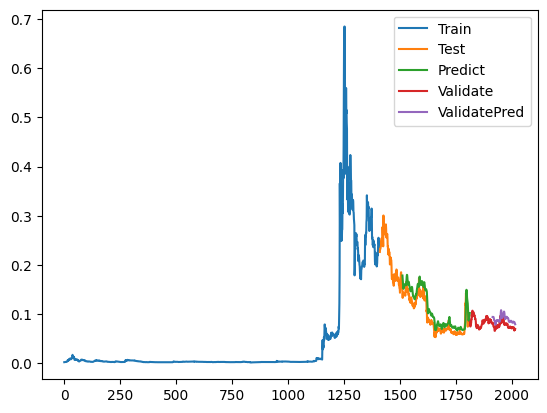

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [ ]:
val_data.shape

(203, 1)

In [ ]:
# Predict 7days
x_input=val_data[102:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.11560066 0.11012236 0.10687167 0.10722147 0.10723611 0.10612815
 0.10185732 0.09432995 0.09410456 0.09521836 0.10166852 0.10465429
 0.10720976 0.10000732 0.10418155 0.1097301  0.10466746 0.10724782
 0.10237984 0.1102936  0.10605644 0.11105175 0.10705316 0.10612229
 0.10666823 0.1044406  0.10579883 0.1084392  0.10641648 0.11049997
 0.12076868 0.11350623 0.13837304 0.13702652 0.13359873 0.12276067
 0.11843422 0.11689596 0.11965488 0.12194105 0.12104092 0.11986418
 0.12579328 0.12769744 0.12797406 0.13016655 0.13159651 0.13531409
 0.1263553  0.12060183 0.11261343 0.11538844 0.11311252 0.11305982
 0.11461565 0.11282418 0.11511768 0.11537233 0.11722527 0.11450149
 0.11311252 0.11309203 0.11441953 0.11256952 0.11541039 0.11044582
 0.11002429 0.10382295 0.10479772 0.10492506 0.10325508 0.10380246
 0.10280428 0.10311017 0.10319799 0.10419764 0.10739125 0.10539342
 0.10536561 0.1055749  0.1033385  0.10459136 0.10439524 0.1012792
 0.1014841  0.10164363 0.10413032 0.10549148 0.1048

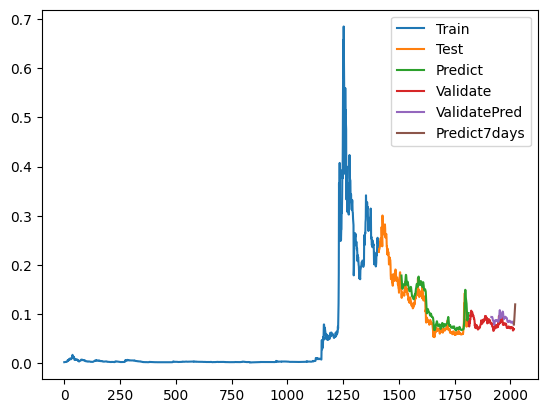

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

## 5:3:2

In [ ]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [ ]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [ ]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [ ]:
model1=Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model1.add(LSTM(50,return_sequences=True))
model1.add(LSTM(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 13s 372ms/step - loss: 6.8479e-05 - val_loss: 0.1147
Epoch 2/100
15/15 [==============================] - 3s 231ms/step - loss: 9.8385e-06 - val_loss: 0.1090
Epoch 3/100
15/15 [==============================] - 5s 368ms/step - loss: 3.4921e-06 - val_loss: 0.1058
Epoch 4/100
15/15 [==============================] - 4s 231ms/step - loss: 2.5458e-06 - val_loss: 0.1035
Epoch 5/100
15/15 [==============================] - 4s 241ms/step - loss: 2.4176e-06 - val_loss: 0.1011
Epoch 6/100
15/15 [==============================] - 3s 229ms/step - loss: 2.1792e-06 - val_loss: 0.0984
Epoch 7/100
15/15 [==============================] - 5s 361ms/step - loss: 2.0582e-06 - val_loss: 0.0957
Epoch 8/100
15/15 [==============================] - 4s 240ms/step - loss: 2.0136e-06 - val_loss: 0.0928
Epoch 9/100
15/15 [==============================] - 3s 229ms/step - loss: 1.9081e-06 - val_loss: 0.0893
Epoch 10/100
15/15 [==============================] - 

In [ ]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 1s 64ms/step


In [ ]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

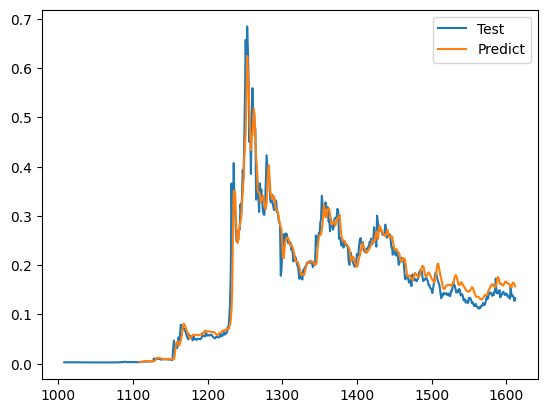

In [ ]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1 + test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start = train_size1 + 101, stop = train_size1 + test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

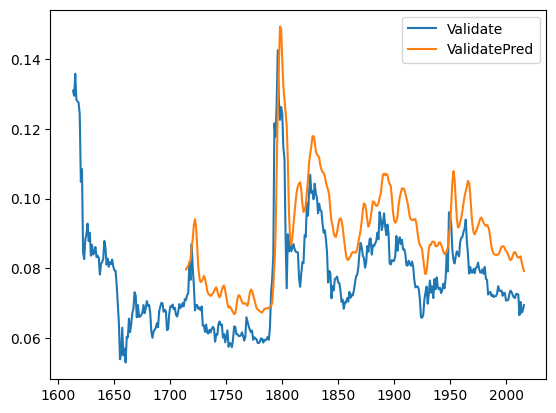

In [ ]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 21.909527027530544
MAE: 0.02627023180977499
RMSE: 0.033256376466094056
--------------------------
---------TEST----------
MAPE: 339.4951354465449
MAE: 0.16907350696383622
RMSE: 0.2179344438619822
-------------------


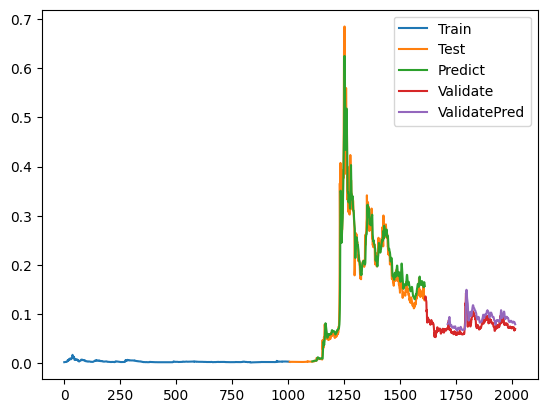

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [ ]:
val_data1.shape

(404, 1)

In [ ]:
x_input=val_data1[303:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps_1=100
i=0

while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps_1, 1))
        #print(x_input)
        yhat = model1.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps_1,1))
        yhat = model1.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.11560066 0.11012236 0.10687167 0.10722147 0.10723611 0.10612815
 0.10185732 0.09432995 0.09410456 0.09521836 0.10166852 0.10465429
 0.10720976 0.10000732 0.10418155 0.1097301  0.10466746 0.10724782
 0.10237984 0.1102936  0.10605644 0.11105175 0.10705316 0.10612229
 0.10666823 0.1044406  0.10579883 0.1084392  0.10641648 0.11049997
 0.12076868 0.11350623 0.13837304 0.13702652 0.13359873 0.12276067
 0.11843422 0.11689596 0.11965488 0.12194105 0.12104092 0.11986418
 0.12579328 0.12769744 0.12797406 0.13016655 0.13159651 0.13531409
 0.1263553  0.12060183 0.11261343 0.11538844 0.11311252 0.11305982
 0.11461565 0.11282418 0.11511768 0.11537233 0.11722527 0.11450149
 0.11311252 0.11309203 0.11441953 0.11256952 0.11541039 0.11044582
 0.11002429 0.10382295 0.10479772 0.10492506 0.10325508 0.10380246
 0.10280428 0.10311017 0.10319799 0.10419764 0.10739125 0.10539342
 0.10536561 0.1055749  0.1033385  0.10459136 0.10439524 0.1012792
 0.1014841  0.10164363 0.10413032 0.10549148 0.1048

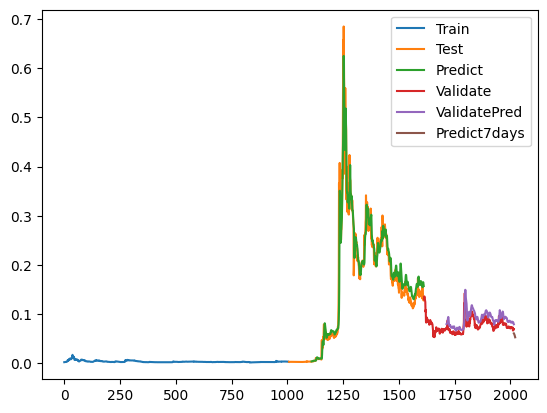

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

## 6:2:2

In [ ]:
train_size2 = int(0.6 * len(df1))
test_size2 = int(0.2 * len(df1))
val_size2 = len(df1) - train_size2 - test_size2

train_data2 = df1[:train_size2]
test_data2 = df1[train_size2:train_size2 + test_size2]
val_data2 = df1[train_size2 + test_size2:]

In [ ]:
time_step = 100
X_train2, y_train2 = create_dataset(train_data2, time_step)
X_val2, yval2 = create_dataset(val_data2, time_step)
X_test2, ytest2 = create_dataset(test_data2, time_step)

In [ ]:
X_train2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1], 1)
X_test2 = X_test2.reshape(X_test2.shape[0],X_test2.shape[1], 1)
X_val2 = X_val2.reshape(X_val2.shape[0],X_val2.shape[1], 1)

In [ ]:
model2=Sequential()
model2.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model2.add(LSTM(50,return_sequences=True))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_16 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(X_train2,y_train2,validation_data=(X_test2,ytest2),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 [==============================] - 14s 454ms/step - loss: 1.7986e-04 - val_loss: 0.0020
Epoch 2/100
18/18 [==============================] - 4s 223ms/step - loss: 6.6648e-05 - val_loss: 0.0014
Epoch 3/100
18/18 [==============================] - 4s 238ms/step - loss: 3.8625e-05 - val_loss: 0.0022
Epoch 4/100
18/18 [==============================] - 6s 326ms/step - loss: 3.9804e-05 - val_loss: 0.0016
Epoch 5/100
18/18 [==============================] - 4s 212ms/step - loss: 3.3949e-05 - val_loss: 0.0013
Epoch 6/100
18/18 [==============================] - 4s 222ms/step - loss: 3.0938e-05 - val_loss: 0.0020
Epoch 7/100
18/18 [==============================] - 6s 352ms/step - loss: 3.0273e-05 - val_loss: 0.0013
Epoch 8/100
18/18 [==============================] - 4s 238ms/step - loss: 2.6874e-05 - val_loss: 8.3595e-04
Epoch 9/100
18/18 [==============================] - 4s 215ms/step - loss: 2.3110e-05 - val_loss: 9.3197e-04
Epoch 10/100
18/18 [==========================

In [ ]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

10/10 [==============================] - 1s 68ms/step


In [ ]:
train_predict2 = scaler.inverse_transform(train_predict2)
y_pred2 = scaler.inverse_transform(y_pred2)
y_pred_val2 = scaler.inverse_transform(y_pred_val2)

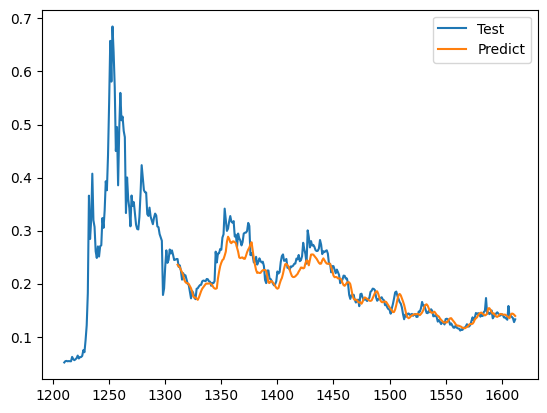

In [ ]:
test_data_index2 = pd.RangeIndex(start=train_size2, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,scaler.inverse_transform(test_data2))

test_data_index2 = pd.RangeIndex(start=train_size2+101, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,(y_pred2))

plt.legend(['Test','Predict'])
plt.show()

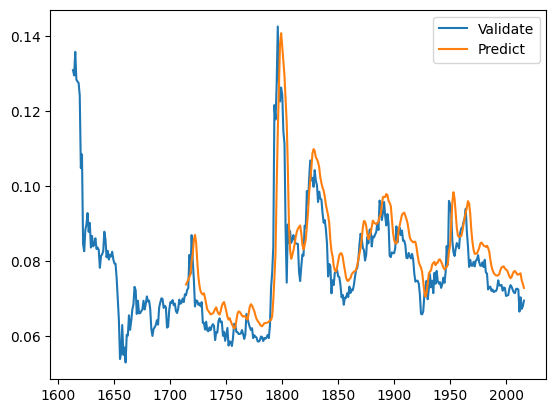

In [ ]:
val_data_index2 = pd.RangeIndex(start=train_size2+test_size2, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,scaler.inverse_transform(val_data2))

val_data_index2 = pd.RangeIndex(start=train_size2+test_size2+101, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,y_pred_val2)

plt.legend(['Validate','Predict'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape2 = np.mean(np.abs((yval2 - y_pred_val2) / yval2)) * 100
print('MAPE:', valid_mape2)

valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mape2 = np.mean(np.abs((ytest2 - y_pred2) / ytest2)) * 100
print('MAPE:', test_mape2)

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAPE: 26.62079814168856
MAE: 0.031799891463729725
RMSE: 0.0384155411187424
--------------------------
---------TEST----------
MAPE: 34.43512584073633
MAE: 0.10816467206361664
RMSE: 0.1342797357890674
-------------------


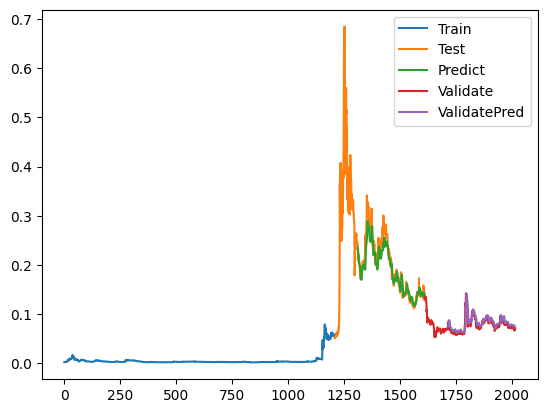

In [ ]:
train_data_index2 = pd.RangeIndex(start=0, stop=train_size2, step=1)
plt.plot(scaler.inverse_transform(train_data2))

test_data_index2 = pd.RangeIndex(start=train_size2, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,scaler.inverse_transform(test_data2))
test_data_index2 = pd.RangeIndex(start=train_size2+101, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,(y_pred2))

val_data_index2 = pd.RangeIndex(start=train_size2+test_size2, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,scaler.inverse_transform(val_data2))
val_data_index2 = pd.RangeIndex(start=train_size2+test_size2+101, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,y_pred_val2)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [ ]:
val_data2.shape

(404, 1)

In [ ]:
# Predict 7 days
x_input=val_data2[303:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model2.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model2.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.11560066 0.11012236 0.10687167 0.10722147 0.10723611 0.10612815
 0.10185732 0.09432995 0.09410456 0.09521836 0.10166852 0.10465429
 0.10720976 0.10000732 0.10418155 0.1097301  0.10466746 0.10724782
 0.10237984 0.1102936  0.10605644 0.11105175 0.10705316 0.10612229
 0.10666823 0.1044406  0.10579883 0.1084392  0.10641648 0.11049997
 0.12076868 0.11350623 0.13837304 0.13702652 0.13359873 0.12276067
 0.11843422 0.11689596 0.11965488 0.12194105 0.12104092 0.11986418
 0.12579328 0.12769744 0.12797406 0.13016655 0.13159651 0.13531409
 0.1263553  0.12060183 0.11261343 0.11538844 0.11311252 0.11305982
 0.11461565 0.11282418 0.11511768 0.11537233 0.11722527 0.11450149
 0.11311252 0.11309203 0.11441953 0.11256952 0.11541039 0.11044582
 0.11002429 0.10382295 0.10479772 0.10492506 0.10325508 0.10380246
 0.10280428 0.10311017 0.10319799 0.10419764 0.10739125 0.10539342
 0.10536561 0.1055749  0.1033385  0.10459136 0.10439524 0.1012792
 0.1014841  0.10164363 0.10413032 0.10549148 0.1048

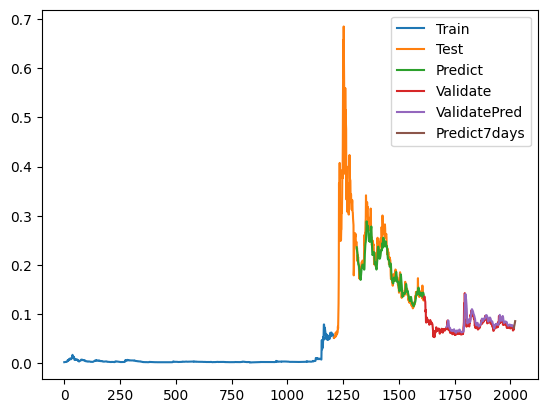

In [ ]:
train_data_index2 = pd.RangeIndex(start=0, stop=train_size2, step=1)
plt.plot(scaler.inverse_transform(train_data2))

test_data_index2 = pd.RangeIndex(start=train_size2, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,scaler.inverse_transform(test_data2))

test_data_index2 = pd.RangeIndex(start=train_size2+101, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,(y_pred2))

val_data_index2 = pd.RangeIndex(start=train_size2+test_size2, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,scaler.inverse_transform(val_data2))
val_data_index2 = pd.RangeIndex(start=train_size2+test_size2+101, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,y_pred_val2)

prediect_data_index2 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index2,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

# XLM

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/XLM-USD.csv')
df1=df.reset_index()['Close']
df1

0       0.089883
1       0.093816
2       0.089035
3       0.097610
4       0.123523
          ...   
2012    0.087906
2013    0.089685
2014    0.087353
2015    0.087150
2016    0.088990
Name: Close, Length: 2017, dtype: float64

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:2:1

In [ ]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 34s 618ms/step - loss: 0.0122 - val_loss: 0.0014
Epoch 2/100
21/21 [==============================] - 9s 456ms/step - loss: 0.0031 - val_loss: 3.6079e-04
Epoch 3/100
21/21 [==============================] - 6s 282ms/step - loss: 0.0025 - val_loss: 6.8548e-04
Epoch 4/100
21/21 [==============================] - 5s 255ms/step - loss: 0.0022 - val_loss: 3.1910e-04
Epoch 5/100
21/21 [==============================] - 6s 274ms/step - loss: 0.0020 - val_loss: 3.2273e-04
Epoch 6/100
21/21 [==============================] - 4s 213ms/step - loss: 0.0019 - val_loss: 5.3832e-04
Epoch 7/100
21/21 [==============================] - 6s 267ms/step - loss: 0.0020 - val_loss: 4.3316e-04
Epoch 8/100
21/21 [==============================] - 6s 270ms/step - loss: 0.0015 - val_loss: 8.8428e-04
Epoch 9/100
21/21 [==============================] - 5s 226ms/step - loss: 0.0014 - val_loss: 4.2070e-04
Epoch 10/100
21/21 [==============================] - 7s 3

In [ ]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 40ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

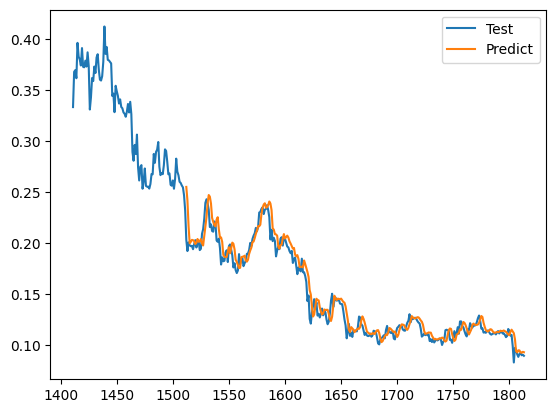

In [ ]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

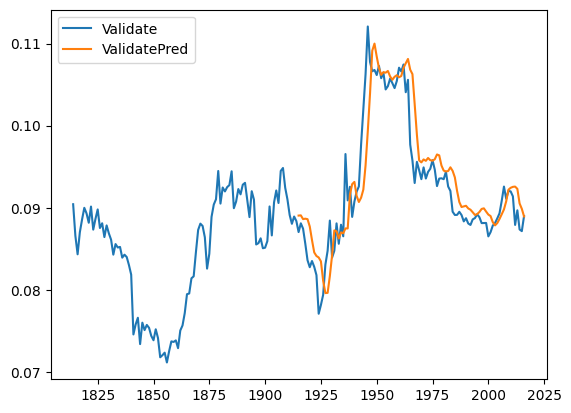

In [ ]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 38.492640377856596
MAE: 0.024967983223416593
RMSE: 0.02752363243033043
--------------------------
---------TEST----------
MAPE: 49.04005688844026
MAE: 0.05543632801590548
RMSE: 0.06869159442986567
-------------------


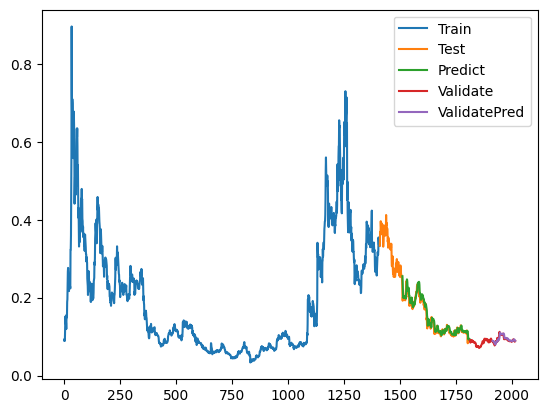

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [ ]:
val_data.shape

(203, 1)

In [ ]:
# Predict 7days
x_input=val_data[102:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.06260069 0.06047502 0.05814072 0.05715438 0.05802945 0.0572077
 0.05603707 0.05058613 0.05182514 0.05326234 0.05751832 0.05947478
 0.06374118 0.05851277 0.05947709 0.0633448  0.06046691 0.06315471
 0.06152047 0.07313749 0.06659125 0.06851062 0.06426043 0.06643363
 0.06782795 0.06856625 0.07449472 0.07933369 0.08441027 0.09115007
 0.08613723 0.08482404 0.08501181 0.08429205 0.08558669 0.08384466
 0.08463281 0.08226026 0.08272272 0.08378323 0.08315272 0.08244802
 0.0834587  0.08533055 0.08479623 0.08578373 0.08186735 0.08361633
 0.0744669  0.07223112 0.06904609 0.0720364  0.07085418 0.06958736
 0.07125174 0.06967776 0.07061311 0.07105818 0.07227168 0.07094112
 0.0686103  0.06966965 0.06971138 0.0695862  0.07063629 0.06855234
 0.0679253  0.06499642 0.06453512 0.0645444  0.06498019 0.06452122
 0.06362643 0.06407382 0.06333204 0.06312226 0.06390692 0.06409353
 0.06463132 0.06421871 0.06338304 0.06339927 0.06340622 0.06150888
 0.0621081  0.06303996 0.06339347 0.06404485 0.0647

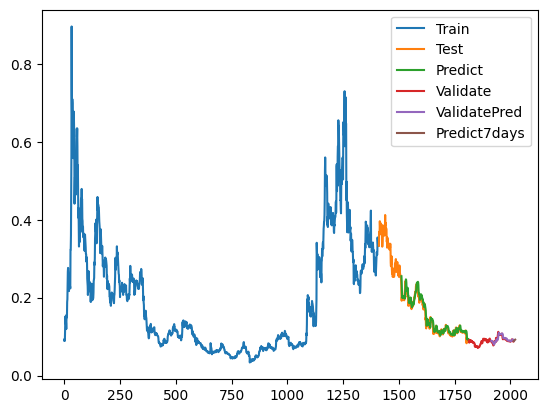

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

## 5:3:2

In [ ]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [ ]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [ ]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [ ]:
model1=Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model1.add(LSTM(50,return_sequences=True))
model1.add(LSTM(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 14s 387ms/step - loss: 0.0094 - val_loss: 0.0216
Epoch 2/100
15/15 [==============================] - 5s 342ms/step - loss: 0.0019 - val_loss: 0.0095
Epoch 3/100
15/15 [==============================] - 4s 238ms/step - loss: 0.0013 - val_loss: 0.0067
Epoch 4/100
15/15 [==============================] - 4s 258ms/step - loss: 9.7875e-04 - val_loss: 0.0048
Epoch 5/100
15/15 [==============================] - 6s 406ms/step - loss: 8.5071e-04 - val_loss: 0.0039
Epoch 6/100
15/15 [==============================] - 4s 254ms/step - loss: 8.0403e-04 - val_loss: 0.0039
Epoch 7/100
15/15 [==============================] - 4s 250ms/step - loss: 6.9770e-04 - val_loss: 0.0035
Epoch 8/100
15/15 [==============================] - 4s 298ms/step - loss: 6.6791e-04 - val_loss: 0.0037
Epoch 9/100
15/15 [==============================] - 5s 314ms/step - loss: 5.8679e-04 - val_loss: 0.0038
Epoch 10/100
15/15 [==============================] - 4s 241ms/ste

In [ ]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 1s 68ms/step


In [ ]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

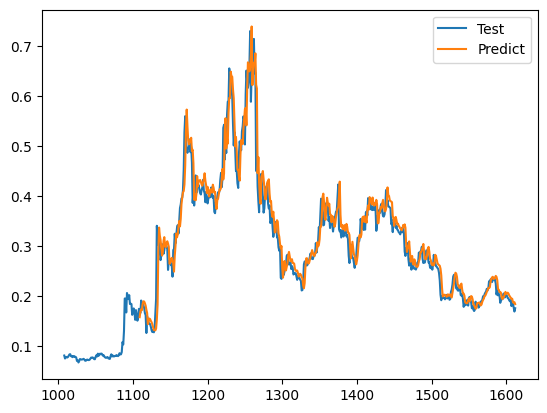

In [ ]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1 + test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start = train_size1 + 101, stop = train_size1 + test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

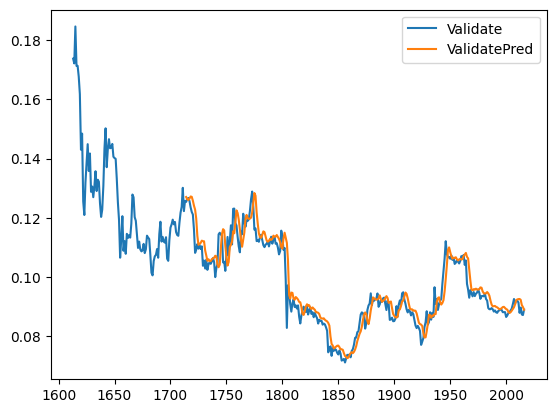

In [ ]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 42.696778526150524
MAE: 0.027100337135771455
RMSE: 0.03216094130773273
--------------------------
---------TEST----------
MAPE: 46.39095709362231
MAE: 0.13636973704888591
RMSE: 0.17587294405339715
-------------------


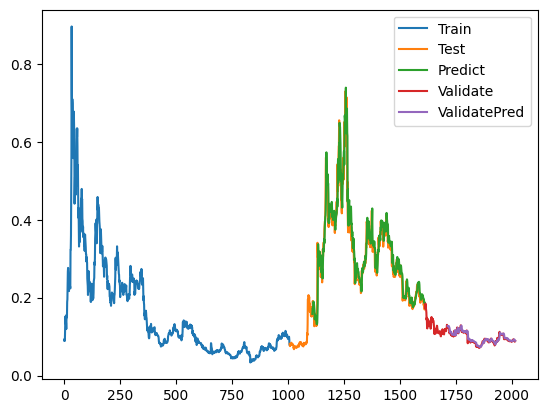

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [ ]:
val_data1.shape

(404, 1)

In [ ]:
x_input=val_data1[303:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps_1=100
i=0

while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps_1, 1))
        #print(x_input)
        yhat = model1.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps_1,1))
        yhat = model1.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.06260069 0.06047502 0.05814072 0.05715438 0.05802945 0.0572077
 0.05603707 0.05058613 0.05182514 0.05326234 0.05751832 0.05947478
 0.06374118 0.05851277 0.05947709 0.0633448  0.06046691 0.06315471
 0.06152047 0.07313749 0.06659125 0.06851062 0.06426043 0.06643363
 0.06782795 0.06856625 0.07449472 0.07933369 0.08441027 0.09115007
 0.08613723 0.08482404 0.08501181 0.08429205 0.08558669 0.08384466
 0.08463281 0.08226026 0.08272272 0.08378323 0.08315272 0.08244802
 0.0834587  0.08533055 0.08479623 0.08578373 0.08186735 0.08361633
 0.0744669  0.07223112 0.06904609 0.0720364  0.07085418 0.06958736
 0.07125174 0.06967776 0.07061311 0.07105818 0.07227168 0.07094112
 0.0686103  0.06966965 0.06971138 0.0695862  0.07063629 0.06855234
 0.0679253  0.06499642 0.06453512 0.0645444  0.06498019 0.06452122
 0.06362643 0.06407382 0.06333204 0.06312226 0.06390692 0.06409353
 0.06463132 0.06421871 0.06338304 0.06339927 0.06340622 0.06150888
 0.0621081  0.06303996 0.06339347 0.06404485 0.0647

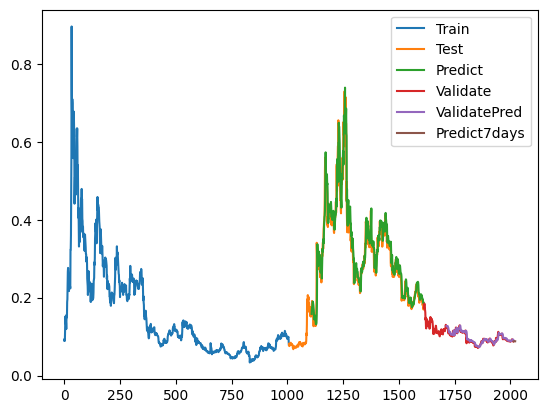

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()

## 6:2:2

In [ ]:
train_size2 = int(0.6 * len(df1))
test_size2 = int(0.2 * len(df1))
val_size2 = len(df1) - train_size2 - test_size2

train_data2 = df1[:train_size2]
test_data2 = df1[train_size2:train_size2 + test_size2]
val_data2 = df1[train_size2 + test_size2:]

In [ ]:
time_step = 100
X_train2, y_train2 = create_dataset(train_data2, time_step)
X_val2, yval2 = create_dataset(val_data2, time_step)
X_test2, ytest2 = create_dataset(test_data2, time_step)

In [ ]:
X_train2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1], 1)
X_test2 = X_test2.reshape(X_test2.shape[0],X_test2.shape[1], 1)
X_val2 = X_val2.reshape(X_val2.shape[0],X_val2.shape[1], 1)

In [ ]:
model2=Sequential()
model2.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model2.add(LSTM(50,return_sequences=True))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(X_train2,y_train2,validation_data=(X_test2,ytest2),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 [==============================] - 15s 455ms/step - loss: 0.0086 - val_loss: 0.0016
Epoch 2/100
18/18 [==============================] - 4s 246ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 3/100
18/18 [==============================] - 6s 324ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/100
18/18 [==============================] - 4s 240ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/100
18/18 [==============================] - 4s 233ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/100
18/18 [==============================] - 6s 319ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
18/18 [==============================] - 5s 271ms/step - loss: 0.0010 - val_loss: 8.0934e-04
Epoch 8/100
18/18 [==============================] - 4s 245ms/step - loss: 9.5108e-04 - val_loss: 8.0873e-04
Epoch 9/100
18/18 [==============================] - 6s 348ms/step - loss: 9.0352e-04 - val_loss: 7.6392e-04
Epoch 10/100
18/18 [==============================] - 5s 252ms/step - 

In [ ]:
train_predict2 = model2.predict(X_train2)
y_pred2 = model2.predict(X_test2)
y_pred_val2 = model2.predict(X_val2)

10/10 [==============================] - 0s 44ms/step


In [ ]:
train_predict2 = scaler.inverse_transform(train_predict2)
y_pred2 = scaler.inverse_transform(y_pred2)
y_pred_val2 = scaler.inverse_transform(y_pred_val2)

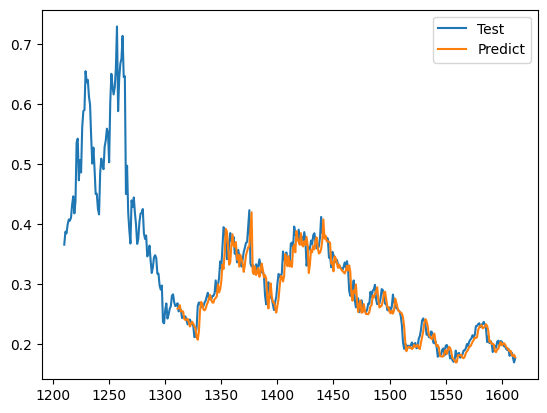

In [ ]:
test_data_index2 = pd.RangeIndex(start=train_size2, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,scaler.inverse_transform(test_data2))

test_data_index2 = pd.RangeIndex(start=train_size2+101, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,(y_pred2))

plt.legend(['Test','Predict'])
plt.show()

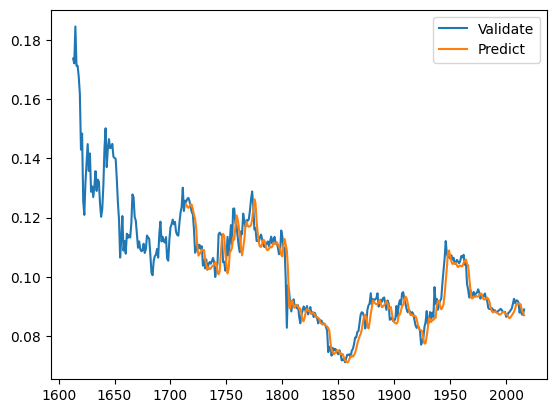

In [ ]:
val_data_index2 = pd.RangeIndex(start=train_size2+test_size2, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,scaler.inverse_transform(val_data2))

val_data_index2 = pd.RangeIndex(start=train_size2+test_size2+101, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,y_pred_val2)

plt.legend(['Validate','Predict'])
plt.show()

In [ ]:
print('---------VALIDATE----------')

valid_mape2 = np.mean(np.abs((yval2 - y_pred_val2) / yval2)) * 100
print('MAPE:', valid_mape2)

valid_mae2 = np.mean(np.abs(y_pred_val2 - yval2))
print('MAE:', valid_mae2)

valid_rmse2 = np.sqrt(np.mean((y_pred_val2 - yval2)**2))
print('RMSE:', valid_rmse2)

print('--------------------------')
print('---------TEST----------')

test_mape2 = np.mean(np.abs((ytest2 - y_pred2) / ytest2)) * 100
print('MAPE:', test_mape2)

test_mae2 = np.mean(np.abs(y_pred2 - ytest2))
print('MAE:', test_mae2)

test_rmse2 = np.sqrt(np.mean((y_pred2 - ytest2)**2))
print('RMSE:', test_rmse2)

print('-------------------')

---------VALIDATE----------
MAPE: 40.24719582482578
MAE: 0.025530580804605234
RMSE: 0.030454813178830704
--------------------------
---------TEST----------
MAPE: 30.8800868451491
MAE: 0.08180547644533429
RMSE: 0.10046816544971353
-------------------


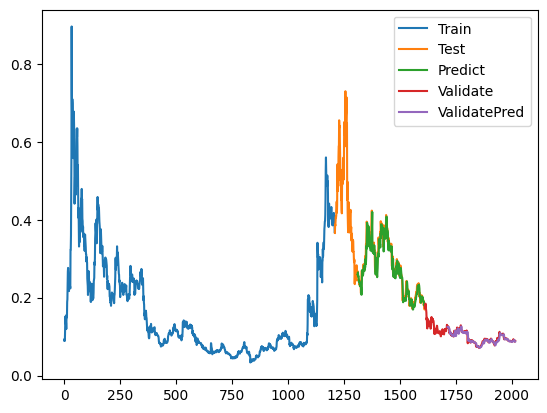

In [ ]:
train_data_index2 = pd.RangeIndex(start=0, stop=train_size2, step=1)
plt.plot(scaler.inverse_transform(train_data2))

test_data_index2 = pd.RangeIndex(start=train_size2, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,scaler.inverse_transform(test_data2))
test_data_index2 = pd.RangeIndex(start=train_size2+101, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,(y_pred2))

val_data_index2 = pd.RangeIndex(start=train_size2+test_size2, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,scaler.inverse_transform(val_data2))
val_data_index2 = pd.RangeIndex(start=train_size2+test_size2+101, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,y_pred_val2)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [ ]:
val_data2.shape

(404, 1)

In [ ]:
# Predict 7 days
x_input=val_data2[303:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model2.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model2.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.06260069 0.06047502 0.05814072 0.05715438 0.05802945 0.0572077
 0.05603707 0.05058613 0.05182514 0.05326234 0.05751832 0.05947478
 0.06374118 0.05851277 0.05947709 0.0633448  0.06046691 0.06315471
 0.06152047 0.07313749 0.06659125 0.06851062 0.06426043 0.06643363
 0.06782795 0.06856625 0.07449472 0.07933369 0.08441027 0.09115007
 0.08613723 0.08482404 0.08501181 0.08429205 0.08558669 0.08384466
 0.08463281 0.08226026 0.08272272 0.08378323 0.08315272 0.08244802
 0.0834587  0.08533055 0.08479623 0.08578373 0.08186735 0.08361633
 0.0744669  0.07223112 0.06904609 0.0720364  0.07085418 0.06958736
 0.07125174 0.06967776 0.07061311 0.07105818 0.07227168 0.07094112
 0.0686103  0.06966965 0.06971138 0.0695862  0.07063629 0.06855234
 0.0679253  0.06499642 0.06453512 0.0645444  0.06498019 0.06452122
 0.06362643 0.06407382 0.06333204 0.06312226 0.06390692 0.06409353
 0.06463132 0.06421871 0.06338304 0.06339927 0.06340622 0.06150888
 0.0621081  0.06303996 0.06339347 0.06404485 0.0647

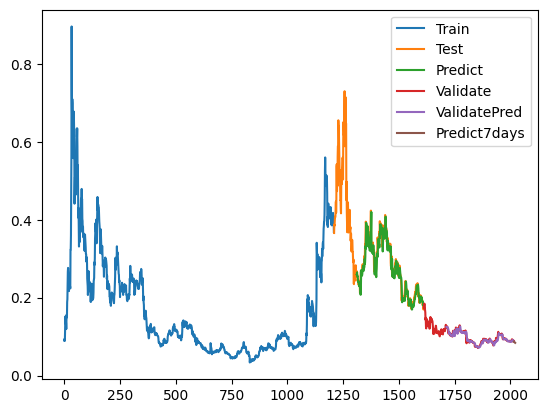

In [ ]:
train_data_index2 = pd.RangeIndex(start=0, stop=train_size2, step=1)
plt.plot(scaler.inverse_transform(train_data2))

test_data_index2 = pd.RangeIndex(start=train_size2, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,scaler.inverse_transform(test_data2))

test_data_index2 = pd.RangeIndex(start=train_size2+101, stop=train_size2+test_size2, step=1)
plt.plot(test_data_index2,(y_pred2))

val_data_index2 = pd.RangeIndex(start=train_size2+test_size2, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,scaler.inverse_transform(val_data2))
val_data_index2 = pd.RangeIndex(start=train_size2+test_size2+101, stop=train_size2+test_size2+val_size2, step=1)
plt.plot(val_data_index2,y_pred_val2)

prediect_data_index2 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+6, step=1)
plt.plot(prediect_data_index2,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict7days'])
plt.show()